In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from statsbombpy import sb
from mplsoccer.pitch import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

In [2]:
print("hola")

hola


Credentials

In [6]:
#Credentials
email = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Team and Colors
team = "América"
team_color = '#DA291C'

comp_id = 73
season_id = 281

path_eff = [path_effects.Stroke(linewidth=2.5, foreground='white'), path_effects.Normal()]

# Custom colormap
colors = ["white", team_color]
n_bins = 100 # Discretizes the interpolation into bins
cmap_name = "team_color_map"
team_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

Get events from statsbomb

In [7]:
# Fetch matches
matches = sb.matches(competition_id=comp_id, season_id=season_id, creds={"user": email, "passwd": password})
matches = matches[(matches['home_team'] == team) | (matches['away_team'] == team)]
matches = matches[matches["match_status"] == "available"]
list_matches = matches['match_id'].tolist()

# Fetch event data
events = []
for n in list_matches:
   match_events = sb.events(match_id = n,creds={"user": email, "passwd": password})
   events.append(match_events)
events=pd.concat(events)

events[['x', 'y','z']] = events['location'].apply(pd.Series)
events[['pass_end_x', 'pass_end_y']] =events['pass_end_location'].apply(pd.Series)

/Users/omaratriano/Documents/TecNM/Local Segundo Semestre/Pawgrammers/back/goalsBack/.venv/lib/python3.12/site-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0, ignore_index=True, sort=True)
/Users/omaratriano/Documents/TecNM/Local Segundo Semestre/Pawgrammers/back/goalsBack/.venv/lib/python3.12/site-packages/statsbombpy/sb.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([*events.values()], axis=0

Prepare the data

In [10]:
# Ensure that related_events is interpreted as a list, if needed
events['related_events'] = events['related_events'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Filter incomplete passes
incomplete_passes = events[(events['type'] == 'Pass') & (events['pass_outcome'] == 'Incomplete')]

# Initialize a new column for the opposition player who intercepts or recovers the pass
events['related_player'] = None

# Create a dictionary for quick lookup of events by their id
event_dict = events.set_index('id').to_dict('index')

# Define the list of related event types to check
related_event_types = ['Interception', 'Recovery','Clearance']

# Define the event types that are relevant for checking aerial duel wins
aerial_duel_event_types = ['Pass', 'Clearance', 'Miscontrol']

# Iterate over each incomplete pass to find the corresponding related event for first contact
for index, pass_event in incomplete_passes.iterrows():
   related_event_ids = pass_event['related_events']

# Iterate over related events to find an event of interest for first contact
   for event_id in related_event_ids:
      if event_id in event_dict:
         related_event = event_dict[event_id]
         if related_event['type'] in related_event_types:
            related_player = related_event['player']
            events.loc[events['id'] == pass_event['id'], 'related_player'] = related_player
            break

# Iterate over each incomplete pass to identify players who win aerial duels
for index, pass_event in incomplete_passes.iterrows():
   related_event_ids = pass_event['related_events']

# Iterate over related events to find an aerial duel win
   for event_id in related_event_ids:
      if event_id in event_dict:
         related_event = event_dict[event_id]
         if (related_event['type'] in aerial_duel_event_types and related_event.get('aerial_won', False)) or \
            related_event.get('clearance_aerial_won', False) or related_event.get('pass_aerial_won', False):
            if related_event['team'] == team and related_event['position'] != 'Goalkeeper':
               related_player = related_event['player']
               events.loc[events['id'] == pass_event['id'], 'aerial_duel_winner'] = related_player
               break

# Fill 'related_player' with 'aerial_duel_winner' where 'related_player' is NaN
events['related_player'].fillna(events['aerial_duel_winner'], inplace=True)

df=events[(events['team']!=team)]
df=df[(df['pass_type']=="Corner")]

conditions=[df['pass_outcome'].isna(),df['pass_outcome'].notna() ]
values=[0,1]
df['success']=np.select(conditions, values)

left=df[(df['y']<=40) & (df['x']>=60)]
right=df[(df['y']>=40)& (df['x']>=60)]

/var/folders/cc/rlwx95ls5cd0lpjds5f8_f400000gn/T/ipykernel_10466/3434639308.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['related_player'] = None
/var/folders/cc/rlwx95ls5cd0lpjds5f8_f400000gn/T/ipykernel_10466/3434639308.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events.loc[events['id'] == pass_event['id'], 'aerial_duel_winner'] = related_player
/var/folders/cc/rlwx95ls5cd0lpjds5f8_f400000gn/T/ipykernel_10466/3434639308.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series 

In [11]:
pitch = VerticalPitch(half=True, pitch_type='statsbomb',
                      pad_left=-15, pad_right=-15, pad_bottom=-37, line_zorder=5)
# Plotting functions
def plot_corners(data,ax,cmap=team_cmap):

   pitch.draw(ax=ax)

   data=data[(data["pass_end_y"]>18)&(data["pass_end_y"]<62)]

   bin_statistic = pitch.bin_statistic(data.pass_end_x, data.pass_end_y, values=data.success,statistic='mean', bins=(20, 13))
   bin_statistic['statistic'] = np.select([bin_statistic['statistic'] == 0], [0.001], bin_statistic['statistic'])
   bin_statistic['statistic'] = np.nan_to_num(bin_statistic['statistic'])
   bin_statistic2 = pitch.bin_statistic(data.pass_end_x, data.pass_end_y,statistic='count', bins=(20,13))
   pitch.heatmap(bin_statistic, ax=ax, cmap=cmap,edgecolor='lightgrey',alpha=0.75)

   pitch.label_heatmap(bin_statistic, color='black', fontsize=26,
      ax=ax, ha='center', va='bottom',fontweight="bold",
      str_format='{:.0%}'
      ,exclude_zeros=True
      ,path_effects=path_eff)

   pitch.label_heatmap(bin_statistic2, color='black', fontsize=18,
      ax=ax, ha='center', va='top',fontweight="bold",
      str_format='({:0.0f})',exclude_zeros=True, path_effects=path_eff)

   ax.set_title(f"Corners ({len(data)})")


def bar_chart(data, ax, color=team_color):
   grouped = data.groupby('related_player').size().reset_index(name='first_contact')
   grouped = grouped[grouped['first_contact'] > 1].sort_values('first_contact', ascending=True)
   bars = grouped['related_player']
   h = grouped['first_contact']
   y_pos = np.arange(len(bars))
   ax.barh(y_pos, h, color=color, lw=5, edgecolor='black')
   ax.set_yticks(y_pos)
   ax.set_yticklabels(bars, color="black", size=20)
   ax.tick_params(bottom=False, top=False, labelbottom=False)
   for side in ["right", "left", "top", "bottom"]:
      ax.spines[side].set_visible(False)
   for i, v in enumerate(h):      ax.text(v - 0.5, i - 0.1, f"{round(v, 3)}", color="white", fontsize=26, ha='center', fontweight="bold")



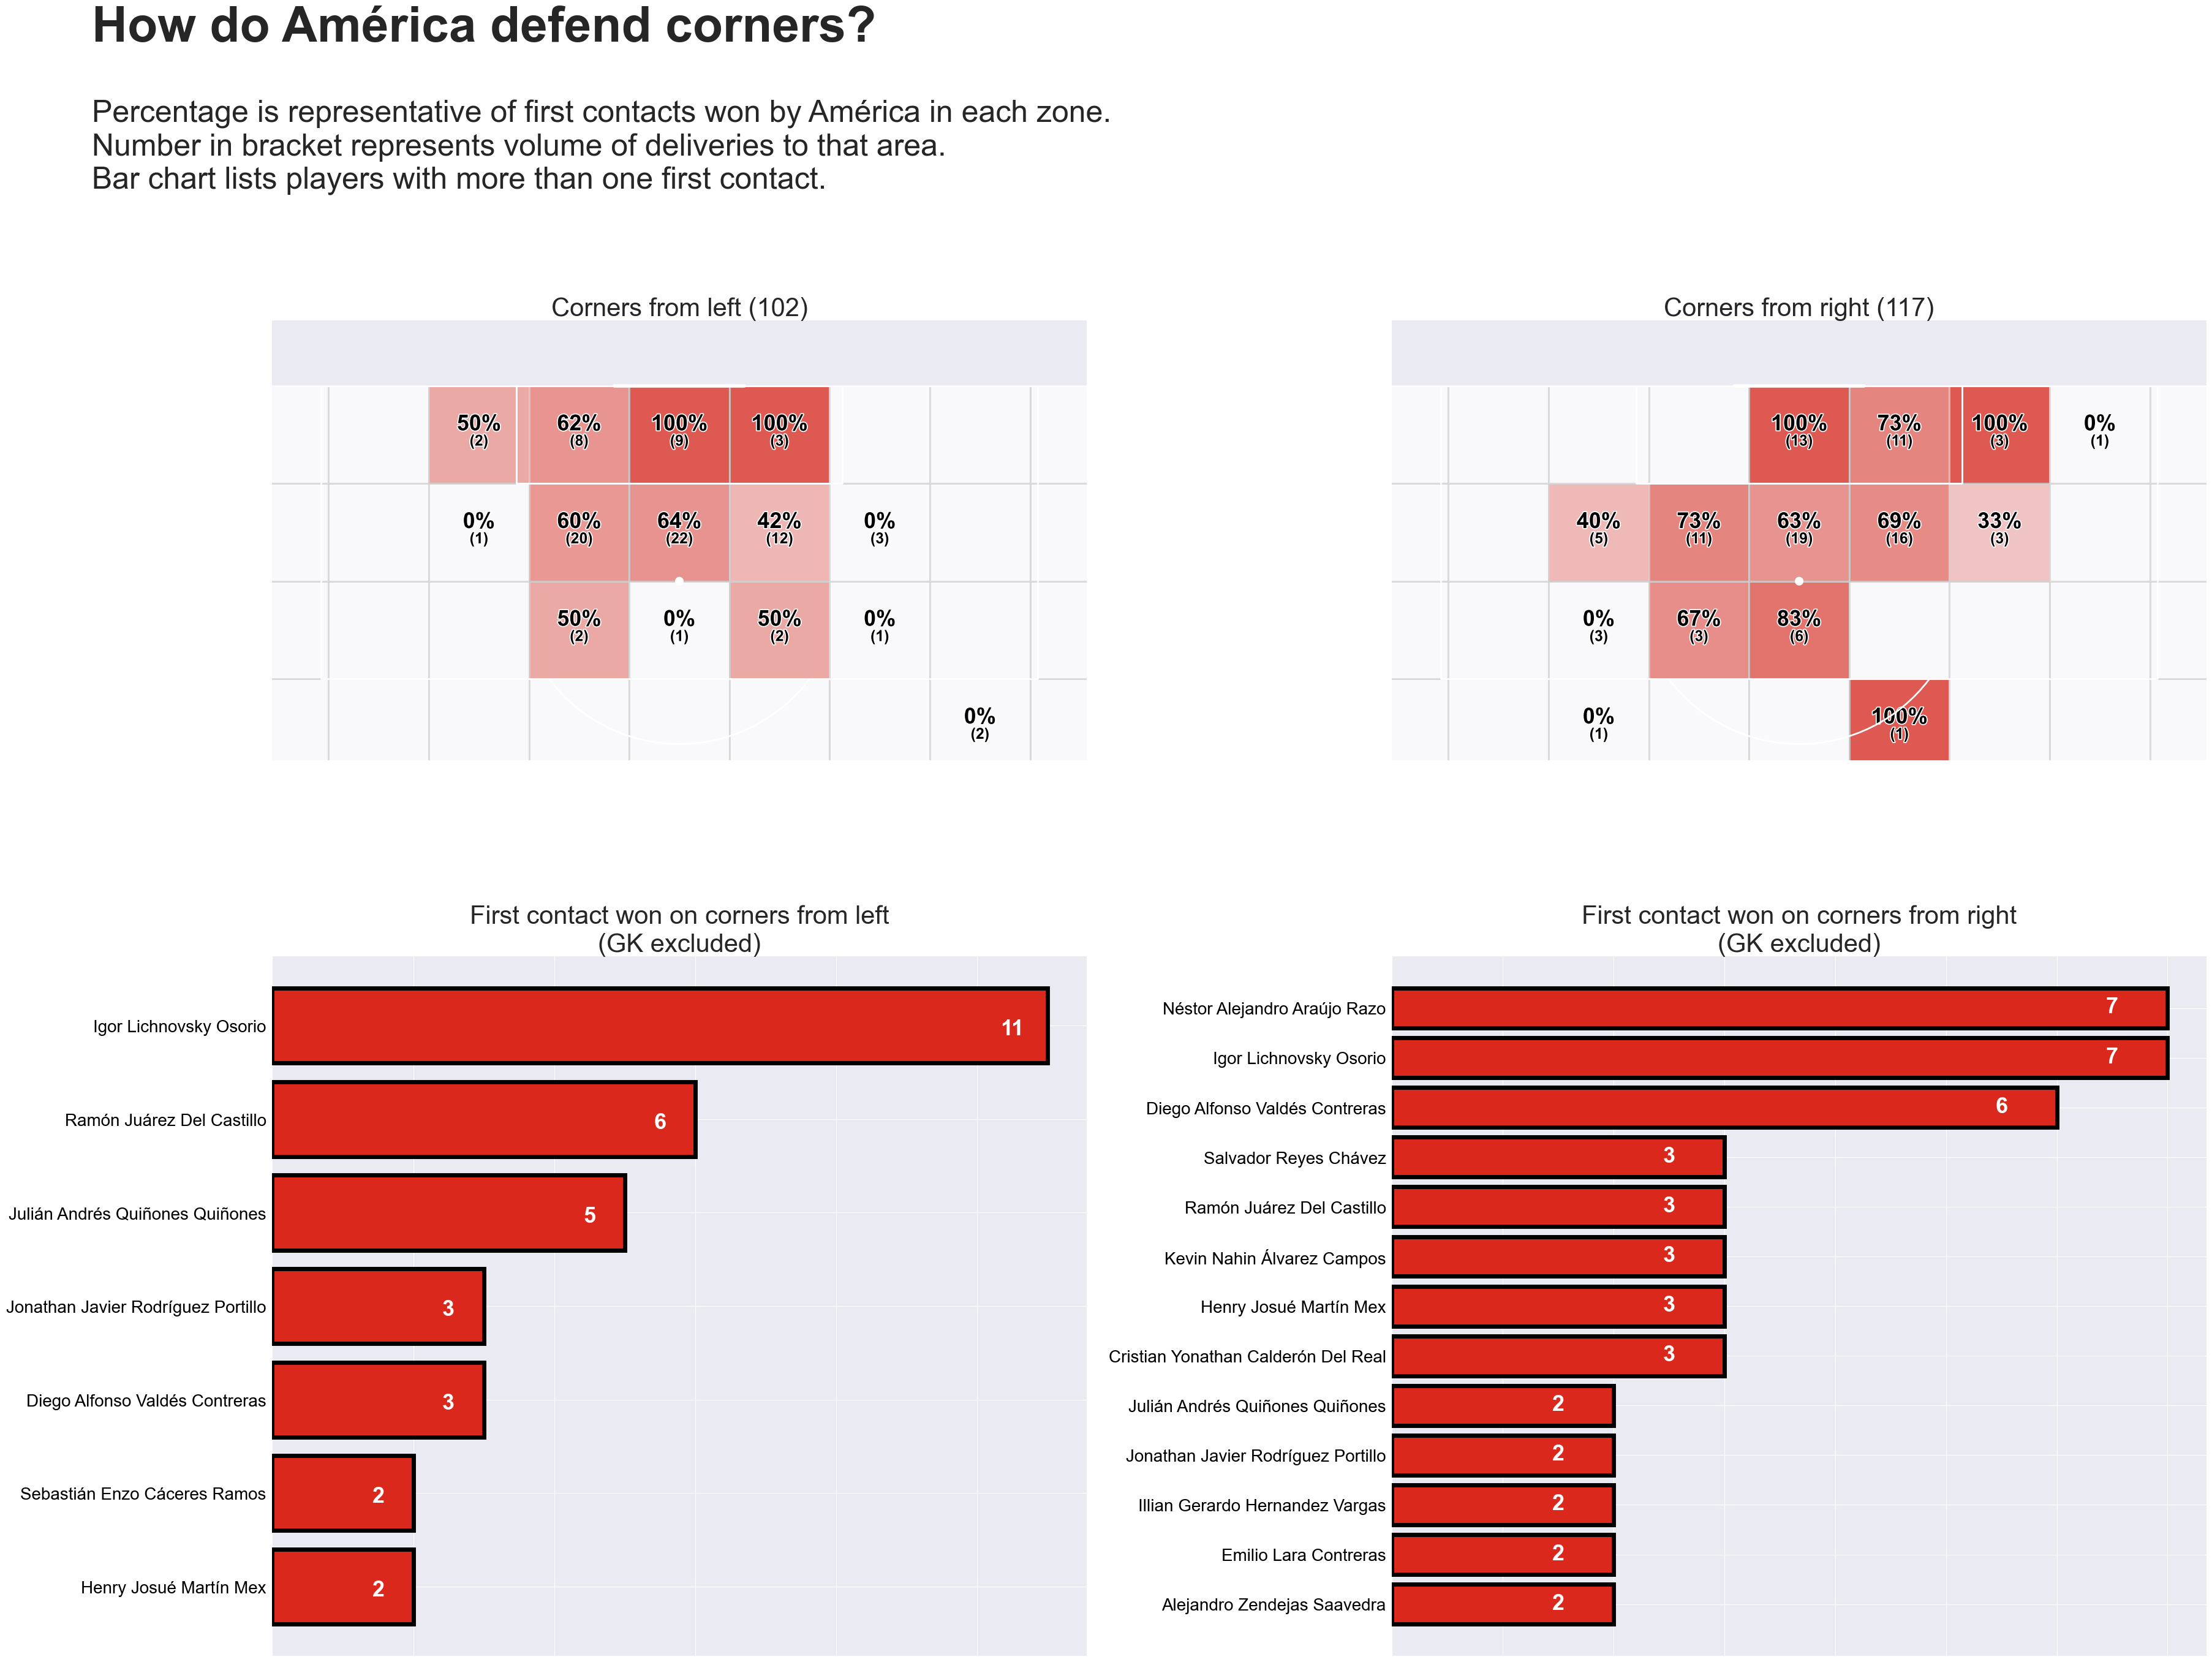

In [12]:
# Create plots
fig, axs = plt.subplots(2, 2, figsize=(36, 24), constrained_layout=True)

# Plot corners
plot_corners(left, axs[0, 0])
axs[0, 0].set_title(f"Corners from left ({len(left)})", size=30)

plot_corners(right, axs[0, 1])
axs[0, 1].set_title(f"Corners from right ({len(right)})", size=30)

# Plot bar charts
bar_chart(left, axs[1, 0])
axs[1, 0].set_title("First contact won on corners from left\n(GK excluded)", size=30)

bar_chart(right, axs[1, 1])
axs[1, 1].set_title("First contact won on corners from right\n(GK excluded)", size=30)

# Add main titles
fig.text(0.04, 1.1, f"How do {team} defend corners?", fontsize=58, fontweight='bold')
fig.text(0.04, 1.0, f"Percentage is representative of first contacts won by {team} in each zone.\n"
                    f"Number in bracket represents volume of deliveries to that area.\n"
                    f"Bar chart lists players with more than one first contact.", fontsize=36)

plt.show()